# 04_offline_tf_cnn_lstm_notebook.ipynb
Offline Training and Evaluation of CNN+LSTM TensorFlow Model
This notebook trains a CNN+LSTM model on 5G throughput data, visualizes loss curves, computes metrics, and displays a Run 14 heatmap.

## 1. Imports and Configuration

In [3]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

## 2. Load and Preprocess Data

In [4]:
# Load dataset
df = pd.read_csv('mm-5G-enriched.csv')
df.drop(columns=['debit_class'], inplace=True, errors='ignore')

# Rolling window parameters
SEQ_LEN = 10
targets = ['debit_brut', 'debit_lisse']
features = df.select_dtypes(include=[np.number]).columns.drop(targets).tolist()

# Build sequences
X, y_raw, y_smooth, runs = [], [], [], []
for run_id, grp in df.groupby('run_num'):
    grp = grp.reset_index(drop=True)
    for i in range(len(grp) - SEQ_LEN):
        X.append(grp.loc[i:i+SEQ_LEN-1, features].values)
        y_raw.append(grp.loc[i+SEQ_LEN, 'debit_brut'])
        y_smooth.append(grp.loc[i+SEQ_LEN, 'debit_lisse'])
        runs.append(run_id)

X = np.stack(X)
y_raw = np.array(y_raw)
y_smooth = np.array(y_smooth)
runs = np.array(runs)

# Scale features
ns, _, nf = X.shape
scaler = MinMaxScaler()
X_flat = scaler.fit_transform(X.reshape(-1, nf))
X = X_flat.reshape(ns, SEQ_LEN, nf)

# Save scaler
joblib.dump(scaler, 'models/scaler.gz')

# Train/validation split
X_train, X_val, y_raw_train, y_raw_val, y_smooth_train, y_smooth_val, runs_train, runs_val = train_test_split(
    X, y_raw, y_smooth, runs, test_size=0.2, random_state=42, shuffle=False
)

## 3. Build and Compile Model

In [5]:
input_layer = layers.Input(shape=(SEQ_LEN, nf))
x = layers.Conv1D(32, 3, padding='same', activation='relu')(input_layer)
x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(64)(x)
raw_output = layers.Dense(1, name='raw')(x)
smooth_output = layers.Dense(1, name='smooth')(x)
model = models.Model(inputs=input_layer, outputs=[raw_output, smooth_output])
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 10, 25)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 10, 32)            │           2,432 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 10, 64)            │           6,208 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 5, 64)             │               0 │ conv1d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 64)                │          33,024 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ raw (Dense)                   │ (None, 1)                 │              65 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ smooth (Dense)                │ (None, 1)                 │              65 │ lstm[0][0]                 │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 41,794 (163.26 KB)

 Trainable params: 41,794 (163.26 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train with Early Stopping

In [8]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, [y_raw_train, y_smooth_train],
    validation_data=(X_val, [y_raw_val, y_smooth_val]),
    epochs=100, batch_size=32, callbacks=[es]
)

# Save model
model.save('models/throughput_model.keras')

Epoch 1/100
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 26304.7246 - raw_loss: 24573.9590 - smooth_loss: 1730.7628 - val_loss: 29938.9883 - val_raw_loss: 27620.8926 - val_smooth_loss: 2273.8770
Epoch 2/100
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 26511.8184 - raw_loss: 24758.7070 - smooth_loss: 1753.1241 - val_loss: 29568.3613 - val_raw_loss: 27362.7129 - val_smooth_loss: 2161.9229
Epoch 3/100
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - loss: 26203.1699 - raw_loss: 24462.9648 - smooth_loss: 1740.2155 - val_loss: 29476.0371 - val_raw_loss: 27346.0664 - val_smooth_loss: 2086.4622
Epoch 4/100
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 26106.8965 - raw_loss: 24382.0078 - smooth_loss: 1724.9115 - val_loss: 30376.7480 - val_raw_loss: 28023.9883 - val_smooth_loss: 2307.9968
Epoch 5/100
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 25685.1523 - raw_loss: 23956.0918 - smooth_loss: 1729.0410 - val_loss: 30437.6426 - val_raw_loss: 27621.4707 - val_smooth_l

## 5. Loss Curves Visualization

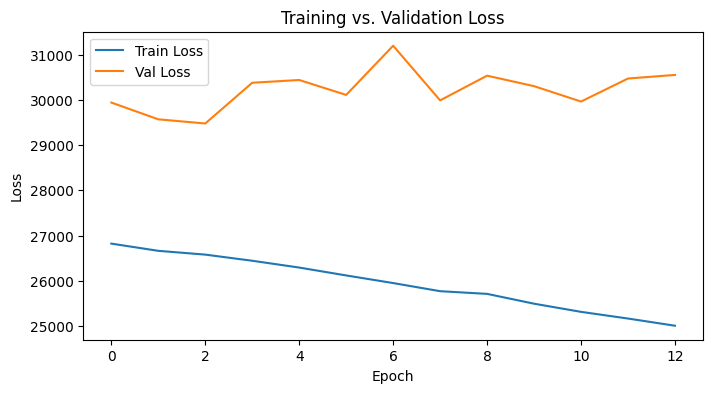

In [9]:
# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6. Evaluation Metrics

In [10]:
# Predictions on validation
pred_raw, pred_smooth = model.predict(X_val)
pred_raw = pred_raw.squeeze()
pred_smooth = pred_smooth.squeeze()

# Switch: choose prediction closest to true raw
pred_final = np.where(
    np.abs(pred_raw - y_raw_val) < np.abs(pred_smooth - y_raw_val),
    pred_raw, pred_smooth
)

# Compute metrics
rmse_raw = np.sqrt(mean_squared_error(y_raw_val, pred_raw))
rmse_smooth = np.sqrt(mean_squared_error(y_smooth_val, pred_smooth))
rmse_final = np.sqrt(mean_squared_error(y_raw_val, pred_final))
mae_final = mean_absolute_error(y_raw_val, pred_final)
r2_final = r2_score(y_raw_val, pred_final)

# Display metrics
metrics = pd.DataFrame({
    'Metric': ['RMSE Raw', 'RMSE Smooth', 'RMSE Final', 'MAE Final', 'R2 Final'],
    'Value': [rmse_raw, rmse_smooth, rmse_final, mae_final, r2_final]
})
metrics

419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


,Metric,Value
0,RMSE Raw,165.488836
1,RMSE Smooth,45.710966
2,RMSE Final,143.637136
3,MAE Final,79.999825
4,R2 Final,0.900409


## 7. Run 14 Heatmap via Folium

In [15]:
# Improved Run Heatmap with Colormap and Circle Markers

import folium
import branca.colormap as cm
from IPython.display import IFrame

# Select a valid run (same logic as before)
valid_runs = np.unique(runs_val)
run_to_plot = 14 if 14 in valid_runs else valid_runs[0]
run_idx = np.where(runs_val == run_to_plot)[0][:20]
coords_df = df[df.run_num == run_to_plot].reset_index(drop=True)
coords = coords_df.loc[run_idx + SEQ_LEN, ['latitude','longitude']].values.tolist()
preds = pred_final[run_idx].tolist()

# Determine map center and bounds
lats, lons = zip(*coords)
center = [np.mean(lats), np.mean(lons)]

# Create map with a nicer tile
m = folium.Map(location=center, zoom_start=14, tiles='CartoDB positron')

# Create and add a linear colormap
vmin, vmax = min(preds), max(preds)
colormap = cm.LinearColormap(
    ['blue','green','yellow','red'],
    vmin=vmin, vmax=vmax,
    caption='Predicted Throughput (Mbps)'
)
colormap.add_to(m)

# Add circle markers sized and colored by throughput
for (lat, lon), val in zip(coords, preds):
    color = colormap(val)
    folium.CircleMarker(
        location=[lat, lon],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=folium.Popup(f'<b>{val:.2f} Mbps</b>', parse_html=True)
    ).add_to(m)

# Fit map to all points
m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])

# Save and display
html_path = 'outputs/run_heatmap_improved.html'
m.save(html_path)
print(f"Improved heatmap saved to {html_path}")

IFrame(html_path, width=800, height=600)


Improved heatmap saved to outputs/run_heatmap_improved.html
